<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-pre-processing-for-image-analysis" data-toc-modified-id="Data-pre-processing-for-image-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data pre processing for image analysis</a></span></li><li><span><a href="#Generate-organ-present-dataframe-plots-and-distributions" data-toc-modified-id="Generate-organ-present-dataframe-plots-and-distributions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate organ present dataframe plots and distributions</a></span></li><li><span><a href="#Cell-resize-datasets-for-analysis-based-on-EDA" data-toc-modified-id="Cell-resize-datasets-for-analysis-based-on-EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cell resize datasets for analysis based on EDA</a></span></li></ul></div>

In [41]:
import numpy as np 
import pandas as pd
import imageio
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [186]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 364B-7A6D

 Directory of C:\Users\niall\OneDrive\Documents\Masters-thesis-EDA-scripts\jupyter notebook

17/10/2019  17:55    <DIR>          .
17/10/2019  17:55    <DIR>          ..
17/10/2019  12:55    <DIR>          .ipynb_checkpoints
17/10/2019  12:55           150,432 EDA grey level visualisation.ipynb
17/10/2019  17:55         1,772,361 EDA on dice coefficients between different masks on different organs.ipynb
17/10/2019  12:55           307,043 EDA Organ size and intensity.ipynb
17/10/2019  12:55           178,949 EDA_Biomedical_image.ipynb
17/10/2019  17:38         3,025,150 slice_no_vs_image_per_org_dice_coeff_t1d_vs_t2spir_imgs.jpeg
17/10/2019  17:37         1,928,047 slice_no_vs_image_type_org_mean_dice_coeff_t1d_vs_t2spir_imgs.jpeg
17/10/2019  15:36           118,282 t2spir_t1dual_organs_pres_in_img_per_pat_slc_no.xlsx
               7 File(s)      7,480,264 bytes
               3 Dir(s)  20,556,455,936 bytes free


# Data pre processing for image analysis

In [119]:
mask_intensities={0:'Background',63:'Liver',126:'r_kidney',189:'l_kidney',252:'spleen'}
inv_org_dict={'Background':0,'Liver':0,'r_kidney':0,'l_kidney':0,'spleen':0}


In [25]:
t1dual_grnd_masks=glob.glob(r'D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\*.png')
t2spir_grnd_masks=glob.glob(r'D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\*.png')

In [ ]:
t1dual_grnd_masks

In [32]:
no_matches_t2_spir=checking_matches(t1dual_grnd_masks,t2spir_grnd_masks,
                     str_chk1='t1dual',str_chk2='t2spir')
no_matches_t1dual=checking_matches(t2spir_grnd_masks,t1dual_grnd_masks,
                     str_chk1='t2spir',str_chk2='t1dual')


In [33]:
t1dual_grnd_masks_filt=sorted([x for x in t1dual_grnd_masks if os.path.basename(x) not in no_matches_t1dual])
t2spir_grnd_masks_filt=sorted([x for x in t2spir_grnd_masks if os.path.basename(x) not in no_matches_t2_spir])
len(t2spir_grnd_masks_filt)

614

In [34]:
grnd_mask_lst_tuple=list(zip(t2spir_grnd_masks_filt,t1dual_grnd_masks_filt))

# Generate organ present dataframe plots and distributions

In [154]:
t2spir_arr_shapes=[]
t1dual_arr_shapes=[]
orgs_pres=[]
orgs_pres_dice_coeff=[]
for t2spir_msks,t1dual_msks in grnd_mask_lst_tuple:
    #Get Patient ID and slice no from image_file_name
    no_in_f_nm=re.findall('\d+',os.path.basename(t2spir_msks))
 
    pat_id=no_in_f_nm[0]
    slc_no=no_in_f_nm[2]

    #import masks masks for images
    t2spir_msks_arr=imageio.imread(t2spir_msks)
    t1dual_msks_arr=imageio.imread(t1dual_msks)
    t2spir_arr_shapes.append(t2spir_msks_arr.shape[0])
    t1dual_arr_shapes.append(t1dual_msks_arr.shape[0])
    
    #Getting unique organs on per slice basis
    uniq_orgs_t2spir=np.unique(t2spir_msks_arr)
    uniq_orgs_t1dual=np.unique(t1dual_msks_arr)
    uniq_vals_set=np.intersect1d(uniq_orgs_t2spir,uniq_orgs_t1dual)
    
    #Getting organs between 
    orgs_in_t2spir=[mask_intensities[k] for k in uniq_orgs_t2spir]
    orgs_in_t1dual=[mask_intensities[k] for k in uniq_orgs_t1dual]
    
    
    #Getting organ types in file analysis
    orgs_in_t2spir_pres={'t2spir_'+k:(1 if k in orgs_in_t2spir else 0) for k,v in inv_org_dict.items()}
    orgs_in_t1dual_pres={'t1dual_'+k:(1 if k in orgs_in_t1dual else 0) for k,v in inv_org_dict.items()}
    orgs_in_t2spir_pres.update(orgs_in_t1dual_pres)
    #Generate organ dice dictionary
    dice_coeff_dict_tmp=gen_org_dice_coeff_per_slc(t2spir_msks_arr,t1dual_msks_arr,uniq_vals_set)
    dice_coeff_dict_tmp['patient_id']=int(pat_id)
    dice_coeff_dict_tmp['slice_no']=int(slc_no)
    #Generate orgs present 
    orgs_in_t2spir_pres['patient_id']=int(pat_id)
    orgs_in_t2spir_pres['slice_no']=int(slc_no)
    #Getting file types to assess
    orgs_pres.append(orgs_in_t2spir_pres)
    orgs_pres_dice_coeff.append(dice_coeff_dict_tmp)
    
betw_img_class_blnc_df=pd.DataFrame(orgs_pres)
betw_img_dice_coeff=pd.DataFrame(orgs_pres_dice_coeff)

In [153]:

def gen_org_dice_coeff_per_slc(t2spir_arr,t1dual_arr,uniq_int_set):
    """Produce dice coefficient between organs in each image type for analysis"""
    
    mask_intensities={0:'Background',63:'Liver',
                      126:'r_kidney',189:'l_kidney',
                      252:'spleen'}

    orgs_pres_inboth_imgs={v:(k if k in uniq_int_set else None) for k,v in mask_intensities.items()}

    for k,v in orgs_pres_inboth_imgs.items():

        if v is not None:
            orgs_pres_inboth_imgs[k]=dice_coeff_bet_imgs(t2spir_msks_arr,t1dual_msks_arr,v)
    
    return orgs_pres_inboth_imgs

In [155]:
betw_img_dice_coeff.head()

,Background,Liver,l_kidney,patient_id,r_kidney,slice_no,spleen
0,0.993195,NaN,NaN,10,0.378449,10,NaN
1,0.990394,NaN,0.000000,10,0.420635,11,NaN
2,0.986921,NaN,0.152269,10,0.438903,12,NaN
3,0.982466,0.000000,0.250000,10,0.459161,13,NaN
4,0.981727,0.265139,0.333913,10,0.486943,14,NaN


In [158]:

dice_coeff_melt=betw_img_dice_coeff.melt(id_vars=['patient_id','slice_no'])
dice_coeff_melt_drp=dice_coeff_melt[~dice_coeff_melt['value'].isin(['NaN'])]
dice_coeff_melt_srt=dice_coeff_melt_drp.sort_values('slice_no',ascending=True)
#trl_melt_srt.to_excel('t2spir_t1dual_organs_pres_in_img_per_pat_slc_no.xlsx')
dice_coeff_melt_srt.head()

,patient_id,slice_no,variable,value
404,36,1,Background,1.000000
132,1,1,Background,1.000000
506,39,1,Background,1.000000
345,33,1,Background,0.999557
167,20,1,Background,1.000000


In [177]:
dice_coeff_melt_srt_agg.head()

,patient_id,slice_no,value
0,1,1,1.0
1,1,2,1.0
2,1,3,1.0
3,1,4,1.0
4,1,5,1.0


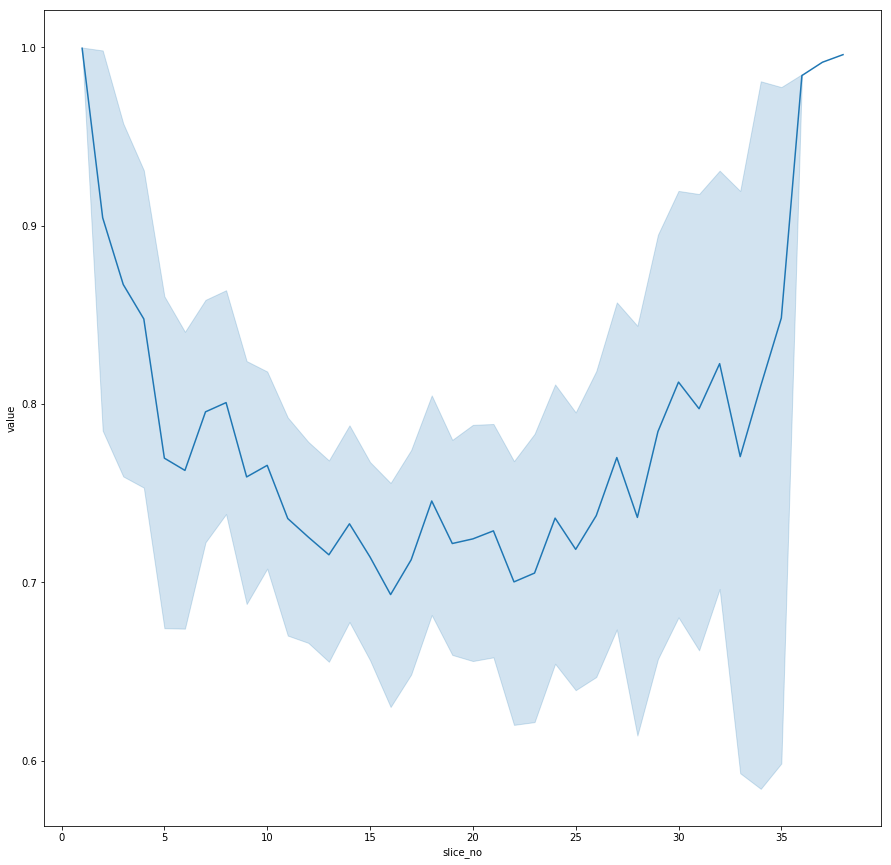

In [184]:
dice_coeff_melt_srt_agg=dice_coeff_melt_srt.groupby(['slice_no']).mean()
dice_coeff_melt_srt_agg.reset_index(inplace=True)

fig,ax=plt.subplots(figsize=(15,15))

sns.lineplot(ax=ax,x="slice_no",y="value",data=dice_coeff_melt_srt)
g=ax.get_figure()
g.savefig('slice_no_vs_image_type_org_mean_dice_coeff_t1d_vs_t2spir_imgs.jpeg',dpi=600)
#dice_coeff_melt_srt_agg.plot.line(x='slice_no',y='value')

In [167]:
dice_coeff_melt_srt_agg.head()

value
patient_id slice_no       
1          1           1.0
           2           1.0
           3           1.0
           4           1.0
           5           1.0

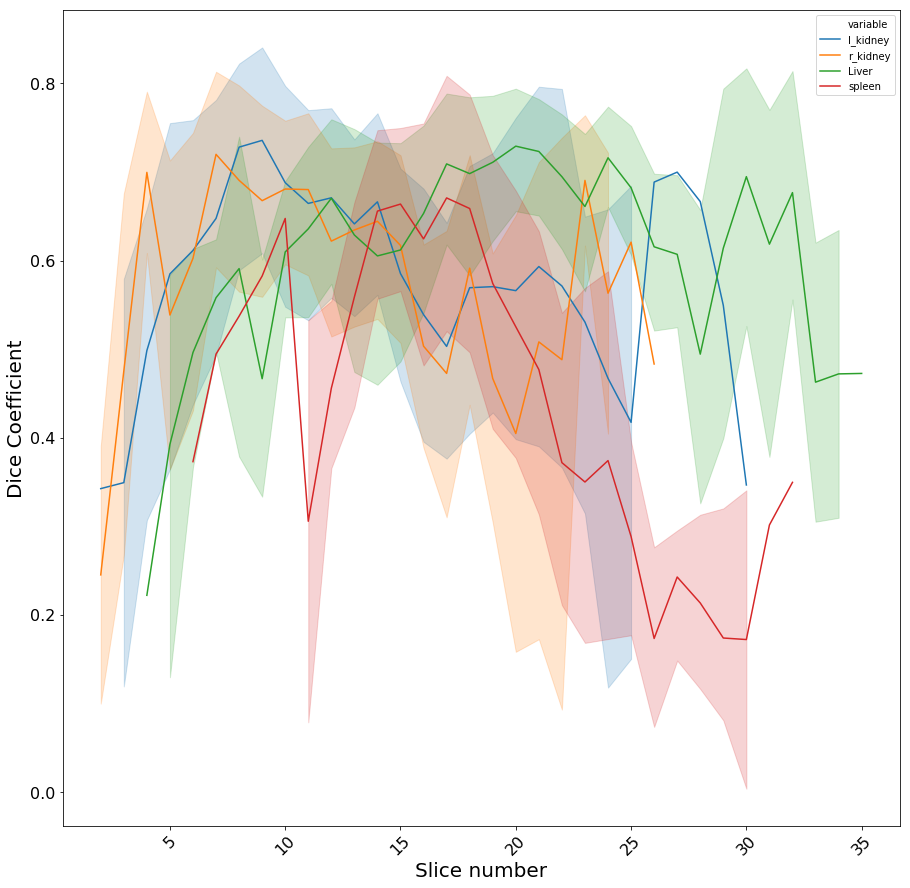

In [185]:
#Getting organs present on per slice basis across different organ types

fig, ax = plt.subplots(figsize=(15,15))
g=sns.lineplot(ax=ax,x="slice_no", y="value", hue="variable",
               data=dice_coeff_melt_srt[~dice_coeff_melt_srt['variable'].isin(['Background'])])#;trl_melt
ax.set_xlabel('Slice number',fontsize=20)
ax.set_ylabel('Dice Coefficient',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', rotation=45)
g=ax.get_figure()
g.savefig('slice_no_vs_image_per_org_dice_coeff_t1d_vs_t2spir_imgs.jpeg',dpi=600)

In [109]:
betw_img_class_blnc_df=pd.DataFrame(orgs_pres)
trl_melt=betw_img_class_blnc_df.melt(id_vars=['patient_id','slice_no'])
trl_melt_drp=trl_melt[~trl_melt['variable'].isin(['t2spir_Background','t1dual_Background'])]
trl_melt_srt=trl_melt_drp.sort_values('slice_no',ascending=True)
trl_melt_srt.to_excel('t2spir_t1dual_organs_pres_in_img_per_pat_slc_no.xlsx')

In [ ]:
#Getting organs present on per slice basis across different organ types

fig, ax = plt.subplots(figsize=(15,15))
g=sns.catplot(ax=ax,x="variable", y="slice_no", hue="value", kind="violin", data=trl_melt_srt,split=True,
            order=['t1dual_Liver','t2spir_Liver','t1dual_spleen','t2spir_spleen',
                  't1dual_l_kidney','t2spir_l_kidney','t1dual_r_kidney','t2spir_r_kidney',])#;trl_melt
ax.set_xlabel('Organ present in Image',fontsize=20)
ax.set_ylabel('Slice number',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', rotation=45)
g=ax.get_figure()
g.savefig('slice_no_vs_image_type_org_pres_violin_plot.jpeg',dpi=600)
#for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
g=sns.catplot(ax=ax,x="variable", y="patient_id", hue="value", kind="violin", data=trl_melt_srt,split=True,
            order=['t1dual_Liver','t2spir_Liver','t1dual_spleen','t2spir_spleen',
                  't1dual_l_kidney','t2spir_l_kidney','t1dual_r_kidney','t2spir_r_kidney',])#;trl_melt
ax.set_xlabel('Organ present in Image',fontsize=20)
ax.set_ylabel('Patient ID',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', rotation=45)
g=ax.get_figure()
g.savefig('patient_vs_image_type_org_pres_violin_plot.jpeg',dpi=600)

In [54]:
t2spir_uniq_dim_cnt=get_uniq_val_list_cnt(t2spir_arr_shapes)
t1dual_uniq_dim_cnt=get_uniq_val_list_cnt(t1dual_arr_shapes)


In [ ]:
gen_bar_chart_from_dict(t2spir_uniq_dim_cnt,'Image square resolution','Frequency per image')

In [ ]:
gen_bar_chart_from_dict(t1dual_uniq_dim_cnt,'Image square resolution','Frequency per image')

In [131]:
def gen_bar_chart_from_dict(D,xlabel,ylabel):
    """the purpose of this method is to generate a bar chart from a dictoinary"""
    
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


In [37]:
def get_uniq_val_list_cnt(arr_list:list)->dict:
    """The purpose of this method is to get the counts of unieu values in a bar chart"""
    uniq_vals=set(arr_list)
    
    ret_dict={}
    for vals in uniq_vals:
        
        i=0
        val_cnt=[i+1 for x in arr_list if x==vals]
        ret_dict[vals]=len(val_cnt)
    return ret_dict

# Cell resize datasets for analysis based on EDA

In [6]:
final_dir=r'D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename'
resize_dim=256

In [15]:
#Analysis in regards to changing the file size to the same 256 x256 size 
for root,subdirs,files in os.walk(final_dir):
    
    if len(files)>0:
        
        for file in files:
            #Set temporary files
            tmp_file_nm=os.path.join(root,file)
            print(tmp_file_nm)
            #resize image
            tmp_file_img=Image.open(tmp_file_nm)
            if tmp_file_img.width!=resize_dim:
                
                tmp_img_resize=tmp_file_img.resize((resize_dim,resize_dim))
                tmp_img_resize.save(tmp_file_nm)
    
        

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_10_t1dual_inphase_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_10_t1dual_inphase_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_10_t1dual_inphase_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_10_t1dual_inphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_10_t1dual_inphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_10_t1dual_inphase_slice_no_1

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_13_t1dual_inphase_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_13_t1dual_inphase_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_13_t1dual_inphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_13_t1dual_inphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_13_t1dual_inphase_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_13_t1dual_inphase_slice_no_1

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_15_t1dual_inphase_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_19_t1dual_inphase_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_19_t1dual_inphase_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_19_t1dual_inphase_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_19_t1dual_inphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_19_t1dual_inphase_slice_no_14

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_1_t1dual_inphase_slice_no_5_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_1_t1dual_inphase_slice_no_6_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_1_t1dual_inphase_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_1_t1dual_inphase_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_1_t1dual_inphase_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_20_t1dual_inphase_slice_no_10_256grey_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_22_t1dual_inphase_slice_no_2_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_22_t1dual_inphase_slice_no_30_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_22_t1dual_inphase_slice_no_31_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_22_t1dual_inphase_slice_no_32_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_22_t1dual_inphase_slice_no_33_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_22_t1dual_inphase_slice_no_34

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_31_t1dual_inphase_slice_no_3_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_31_t1dual_inphase_slice_no_4_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_31_t1dual_inphase_slice_no_5_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_31_t1dual_inphase_slice_no_6_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_31_t1dual_inphase_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_31_t1dual_inphase_slice_no_8_256g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_34_t1dual_inphase_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_34_t1dual_inphase_slice_no_17_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_34_t1dual_inphase_slice_no_18_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_34_t1dual_inphase_slice_no_19_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_34_t1dual_inphase_slice_no_1_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_34_t1dual_inphase_slice_no_20

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_37_t1dual_inphase_slice_no_18_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_37_t1dual_inphase_slice_no_19_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_37_t1dual_inphase_slice_no_1_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_37_t1dual_inphase_slice_no_20_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_37_t1dual_inphase_slice_no_21_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_37_t1dual_inphase_slice_no_22

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_38_t1dual_inphase_slice_no_5_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_38_t1dual_inphase_slice_no_6_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_38_t1dual_inphase_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_38_t1dual_inphase_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_38_t1dual_inphase_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_39_t1dual_inphase_slice_no_10_256

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_3_t1dual_inphase_slice_no_27_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_3_t1dual_inphase_slice_no_28_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_3_t1dual_inphase_slice_no_29_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_3_t1dual_inphase_slice_no_2_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_3_t1dual_inphase_slice_no_30_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_3_t1dual_inphase_slice_no_3_256gre

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_8_t1dual_inphase_slice_no_21_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_8_t1dual_inphase_slice_no_22_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_8_t1dual_inphase_slice_no_23_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_8_t1dual_inphase_slice_no_24_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_8_t1dual_inphase_slice_no_25_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\ground\pat_id_8_t1dual_inphase_slice_no_26_256g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_10_t1dual_inphase_slice_no_35_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_10_t1dual_inphase_slice_no_36_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_10_t1dual_inphase_slice_no_37_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_10_t1dual_inphase_slice_no_38_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_10_t1dual_inphase_slice_no_39_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_10_t1dual_inphase_slice_no_3

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_13_t1dual_inphase_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_13_t1dual_inphase_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_13_t1dual_inphase_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_15_t1dual_inphase_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_15_t1dual_inphase_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_15_t1dual_inphase_slice_no_12_2

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_19_t1dual_inphase_slice_no_2_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_19_t1dual_inphase_slice_no_30_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_19_t1dual_inphase_slice_no_3_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_19_t1dual_inphase_slice_no_4_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_19_t1dual_inphase_slice_no_5_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_19_t1dual_inphase_slice_no_6_256

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_20_t1dual_inphase_slice_no_17_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_20_t1dual_inphase_slice_no_18_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_20_t1dual_inphase_slice_no_19_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_20_t1dual_inphase_slice_no_1_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_20_t1dual_inphase_slice_no_20_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_20_t1dual_inphase_slice_no_21

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_22_t1dual_inphase_slice_no_29_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_22_t1dual_inphase_slice_no_2_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_22_t1dual_inphase_slice_no_30_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_22_t1dual_inphase_slice_no_31_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_22_t1dual_inphase_slice_no_32_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_22_t1dual_inphase_slice_no_33

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_32_t1dual_inphase_slice_no_19_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_32_t1dual_inphase_slice_no_1_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_32_t1dual_inphase_slice_no_20_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_32_t1dual_inphase_slice_no_21_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_32_t1dual_inphase_slice_no_22_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_32_t1dual_inphase_slice_no_23

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_33_t1dual_inphase_slice_no_5_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_33_t1dual_inphase_slice_no_6_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_33_t1dual_inphase_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_33_t1dual_inphase_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_33_t1dual_inphase_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_34_t1dual_inphase_slice_no_10_256

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_36_t1dual_inphase_slice_no_30_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_36_t1dual_inphase_slice_no_31_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_36_t1dual_inphase_slice_no_32_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_36_t1dual_inphase_slice_no_33_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_36_t1dual_inphase_slice_no_34_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_36_t1dual_inphase_slice_no_3

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_38_t1dual_inphase_slice_no_21_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_38_t1dual_inphase_slice_no_22_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_38_t1dual_inphase_slice_no_23_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_38_t1dual_inphase_slice_no_24_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_38_t1dual_inphase_slice_no_25_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_38_t1dual_inphase_slice_no_2

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_3_t1dual_inphase_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_3_t1dual_inphase_slice_no_17_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_3_t1dual_inphase_slice_no_18_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_3_t1dual_inphase_slice_no_19_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_3_t1dual_inphase_slice_no_1_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_3_t1dual_inphase_slice_no_20_256gr

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_8_t1dual_inphase_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_8_t1dual_inphase_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_8_t1dual_inphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_8_t1dual_inphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_8_t1dual_inphase_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_inphase\source\pat_id_8_t1dual_inphase_slice_no_16_256g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_13_t1dual_inphase_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_13_t1dual_inphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_13_t1dual_inphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_13_t1dual_inphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_13_t1dual_inphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_13_t1dual_inphase_slice_no_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_19_t1dual_inphase_slice_no_17_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_19_t1dual_inphase_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_19_t1dual_inphase_slice_no_19_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_19_t1dual_inphase_slice_no_1_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_19_t1dual_inphase_slice_no_20_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_19_t1dual_inphase_slice_no_2

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_1_t1dual_inphase_slice_no_9_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_20_t1dual_inphase_slice_no_10_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_20_t1dual_inphase_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_20_t1dual_inphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_20_t1dual_inphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_20_t1dual_inphase_slice_no_14

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_22_t1dual_inphase_slice_no_34_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_22_t1dual_inphase_slice_no_35_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_22_t1dual_inphase_slice_no_3_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_22_t1dual_inphase_slice_no_4_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_22_t1dual_inphase_slice_no_5_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_22_t1dual_inphase_slice_no_6_6

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_32_t1dual_inphase_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_32_t1dual_inphase_slice_no_19_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_32_t1dual_inphase_slice_no_1_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_32_t1dual_inphase_slice_no_20_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_32_t1dual_inphase_slice_no_21_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_32_t1dual_inphase_slice_no_2

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_34_t1dual_inphase_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_34_t1dual_inphase_slice_no_19_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_34_t1dual_inphase_slice_no_1_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_34_t1dual_inphase_slice_no_20_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_34_t1dual_inphase_slice_no_21_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_34_t1dual_inphase_slice_no_2

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_37_t1dual_inphase_slice_no_4_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_37_t1dual_inphase_slice_no_5_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_37_t1dual_inphase_slice_no_6_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_37_t1dual_inphase_slice_no_7_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_37_t1dual_inphase_slice_no_8_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_37_t1dual_inphase_slice_no_9_64g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_3_t1dual_inphase_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_3_t1dual_inphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_3_t1dual_inphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_3_t1dual_inphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_3_t1dual_inphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_3_t1dual_inphase_slice_no_16_64g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_5_t1dual_inphase_slice_no_7_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_5_t1dual_inphase_slice_no_8_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_5_t1dual_inphase_slice_no_9_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_8_t1dual_inphase_slice_no_10_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_8_t1dual_inphase_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\ground\pat_id_8_t1dual_inphase_slice_no_12_64grey

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_10_t1dual_outphase_slice_no_26_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_10_t1dual_outphase_slice_no_27_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_10_t1dual_outphase_slice_no_28_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_10_t1dual_outphase_slice_no_29_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_10_t1dual_outphase_slice_no_2_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_10_t1dual_outphase

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_13_t1dual_outphase_slice_no_24_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_13_t1dual_outphase_slice_no_25_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_13_t1dual_outphase_slice_no_26_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_13_t1dual_outphase_slice_no_27_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_13_t1dual_outphase_slice_no_28_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_13_t1dual_outphas

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_19_t1dual_outphase_slice_no_19_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_19_t1dual_outphase_slice_no_1_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_19_t1dual_outphase_slice_no_20_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_19_t1dual_outphase_slice_no_21_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_19_t1dual_outphase_slice_no_22_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_19_t1dual_outphase

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_1_t1dual_outphase_slice_no_6_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_1_t1dual_outphase_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_1_t1dual_outphase_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_1_t1dual_outphase_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_20_t1dual_outphase_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_20_t1dual_outphase_slice_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_22_t1dual_outphase_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_22_t1dual_outphase_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_22_t1dual_outphase_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_22_t1dual_outphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_22_t1dual_outphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_22_t1dual_outphas

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_2_t1dual_outphase_slice_no_22_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_2_t1dual_outphase_slice_no_23_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_2_t1dual_outphase_slice_no_24_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_2_t1dual_outphase_slice_no_25_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_2_t1dual_outphase_slice_no_26_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_2_t1dual_outphase_slic

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_32_t1dual_outphase_slice_no_31_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_32_t1dual_outphase_slice_no_32_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_32_t1dual_outphase_slice_no_33_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_32_t1dual_outphase_slice_no_3_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_32_t1dual_outphase_slice_no_4_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_32_t1dual_outphase_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_36_t1dual_outphase_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_36_t1dual_outphase_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_36_t1dual_outphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_36_t1dual_outphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_36_t1dual_outphase_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_36_t1dual_outphas

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_38_t1dual_outphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_38_t1dual_outphase_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_38_t1dual_outphase_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_38_t1dual_outphase_slice_no_17_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_38_t1dual_outphase_slice_no_18_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_38_t1dual_outphas

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_3_t1dual_outphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_3_t1dual_outphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_3_t1dual_outphase_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_3_t1dual_outphase_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_3_t1dual_outphase_slice_no_17_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_3_t1dual_outphase_slic

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_8_t1dual_outphase_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_8_t1dual_outphase_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_8_t1dual_outphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_8_t1dual_outphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_8_t1dual_outphase_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t1dual_outphase\source\pat_id_8_t1dual_outphase_slic

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_10_t2spir_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_10_t2spir_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_10_t2spir_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_13_t2spir_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_13_t2spir_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_13_t2spir_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_p

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_19_t2spir_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_19_t2spir_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_19_t2spir_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_19_t2spir_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_19_t2spir_slice_no_17_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_19_t2spir_slice_no_18_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x25

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_20_t2spir_slice_no_20_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_20_t2spir_slice_no_21_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_20_t2spir_slice_no_22_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_20_t2spir_slice_no_23_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_20_t2spir_slice_no_24_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_20_t2spir_slice_no_25_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x25

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_22_t2spir_slice_no_1_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_22_t2spir_slice_no_20_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_22_t2spir_slice_no_21_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_22_t2spir_slice_no_22_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_22_t2spir_slice_no_23_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_22_t2spir_slice_no_24_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_32_t2spir_slice_no_1_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_32_t2spir_slice_no_20_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_32_t2spir_slice_no_21_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_32_t2spir_slice_no_22_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_32_t2spir_slice_no_23_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_32_t2spir_slice_no_24_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_34_t2spir_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_34_t2spir_slice_no_17_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_34_t2spir_slice_no_18_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_34_t2spir_slice_no_19_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_34_t2spir_slice_no_1_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_34_t2spir_slice_no_20_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_37_t2spir_slice_no_6_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_37_t2spir_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_37_t2spir_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_37_t2spir_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_38_t2spir_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_38_t2spir_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_pn

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_39_t2spir_slice_no_6_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_39_t2spir_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_39_t2spir_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_39_t2spir_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_3_t2spir_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_3_t2spir_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_8_t2spir_slice_no_1_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_8_t2spir_slice_no_20_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_8_t2spir_slice_no_21_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_8_t2spir_slice_no_22_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_8_t2spir_slice_no_23_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\ground\pat_id_8_t2spir_slice_no_24_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_2

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_13_t2spir_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_13_t2spir_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_13_t2spir_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_13_t2spir_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_13_t2spir_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_13_t2spir_slice_no_17_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x25

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_19_t2spir_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_19_t2spir_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_19_t2spir_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_19_t2spir_slice_no_17_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_19_t2spir_slice_no_18_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_19_t2spir_slice_no_19_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x25

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_1_t2spir_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_1_t2spir_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_1_t2spir_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_20_t2spir_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_20_t2spir_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_20_t2spir_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_21_t2spir_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_21_t2spir_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_21_t2spir_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_22_t2spir_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_22_t2spir_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_22_t2spir_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_p

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_2_t2spir_slice_no_4_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_2_t2spir_slice_no_5_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_2_t2spir_slice_no_6_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_2_t2spir_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_2_t2spir_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_2_t2spir_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256gre

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_33_t2spir_slice_no_27_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_33_t2spir_slice_no_28_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_33_t2spir_slice_no_29_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_33_t2spir_slice_no_2_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_33_t2spir_slice_no_3_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_33_t2spir_slice_no_4_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_p

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_38_t2spir_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_38_t2spir_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_38_t2spir_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_38_t2spir_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_38_t2spir_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_38_t2spir_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x25

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_3_t2spir_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_3_t2spir_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_3_t2spir_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_3_t2spir_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_3_t2spir_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_3_t2spir_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_5_t2spir_slice_no_5_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_5_t2spir_slice_no_6_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_5_t2spir_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_5_t2spir_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_5_t2spir_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256grey_lvl\t2spir\source\pat_id_8_t2spir_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_256gr

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_13_t1dual_inphase_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_13_t1dual_inphase_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_13_t1dual_inphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_13_t1dual_inphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_13_t1dual_inphase_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_13_t1dual_inphase_slice_no_16_256g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_15_t1dual_inphase_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_15_t1dual_inphase_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_19_t1dual_inphase_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_19_t1dual_inphase_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_19_t1dual_inphase_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_19_t1dual_inphase_slice_no_13_256gre

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_20_t1dual_inphase_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_20_t1dual_inphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_20_t1dual_inphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_20_t1dual_inphase_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_20_t1dual_inphase_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_20_t1dual_inphase_slice_no_17_256g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_22_t1dual_inphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_22_t1dual_inphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_22_t1dual_inphase_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_22_t1dual_inphase_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_22_t1dual_inphase_slice_no_17_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_22_t1dual_inphase_slice_no_18_256g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_2_t1dual_inphase_slice_no_26_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_2_t1dual_inphase_slice_no_2_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_2_t1dual_inphase_slice_no_3_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_2_t1dual_inphase_slice_no_4_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_2_t1dual_inphase_slice_no_5_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_2_t1dual_inphase_slice_no_6_256grey_lvl_256

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_32_t1dual_inphase_slice_no_6_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_32_t1dual_inphase_slice_no_7_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_32_t1dual_inphase_slice_no_8_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_32_t1dual_inphase_slice_no_9_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_33_t1dual_inphase_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_33_t1dual_inphase_slice_no_11_256grey_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_36_t1dual_inphase_slice_no_1_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_36_t1dual_inphase_slice_no_20_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_36_t1dual_inphase_slice_no_21_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_36_t1dual_inphase_slice_no_22_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_36_t1dual_inphase_slice_no_23_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_36_t1dual_inphase_slice_no_24_256gr

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_38_t1dual_inphase_slice_no_10_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_38_t1dual_inphase_slice_no_11_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_38_t1dual_inphase_slice_no_12_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_38_t1dual_inphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_38_t1dual_inphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_38_t1dual_inphase_slice_no_15_256g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_3_t1dual_inphase_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_3_t1dual_inphase_slice_no_17_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_3_t1dual_inphase_slice_no_18_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_3_t1dual_inphase_slice_no_19_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_3_t1dual_inphase_slice_no_1_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_3_t1dual_inphase_slice_no_20_256grey_lvl

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_8_t1dual_inphase_slice_no_13_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_8_t1dual_inphase_slice_no_14_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_8_t1dual_inphase_slice_no_15_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_8_t1dual_inphase_slice_no_16_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_8_t1dual_inphase_slice_no_17_256grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\ground\pat_id_8_t1dual_inphase_slice_no_18_256grey_lv

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_10_T1DUAL_InPhase_slice_no_31_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_10_T1DUAL_InPhase_slice_no_32_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_10_T1DUAL_InPhase_slice_no_33_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_10_T1DUAL_InPhase_slice_no_34_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_10_T1DUAL_InPhase_slice_no_35_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_10_T1DUAL_InPhase_slice_no_36_64grey_lv

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_13_T1DUAL_InPhase_slice_no_3_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_13_T1DUAL_InPhase_slice_no_4_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_13_T1DUAL_InPhase_slice_no_5_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_13_T1DUAL_InPhase_slice_no_6_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_13_T1DUAL_InPhase_slice_no_7_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_13_T1DUAL_InPhase_slice_no_8_64grey_lvl_256x

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_19_t1dual_inphase_slice_no_27_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_19_t1dual_inphase_slice_no_28_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_19_t1dual_inphase_slice_no_29_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_19_t1dual_inphase_slice_no_2_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_19_t1dual_inphase_slice_no_30_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_19_t1dual_inphase_slice_no_3_64grey_lvl_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_20_t1dual_inphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_20_t1dual_inphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_20_t1dual_inphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_20_t1dual_inphase_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_20_t1dual_inphase_slice_no_17_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_20_t1dual_inphase_slice_no_18_64grey_lv

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_22_t1dual_inphase_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_22_t1dual_inphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_22_t1dual_inphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_22_t1dual_inphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_22_t1dual_inphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_22_t1dual_inphase_slice_no_16_64grey_lv

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_2_t1dual_inphase_slice_no_26_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_2_t1dual_inphase_slice_no_2_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_2_t1dual_inphase_slice_no_3_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_2_t1dual_inphase_slice_no_4_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_2_t1dual_inphase_slice_no_5_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_2_t1dual_inphase_slice_no_6_64grey_lvl_256x256.p

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_32_t1dual_inphase_slice_no_20_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_32_t1dual_inphase_slice_no_21_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_32_t1dual_inphase_slice_no_22_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_32_t1dual_inphase_slice_no_23_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_32_t1dual_inphase_slice_no_24_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_32_t1dual_inphase_slice_no_25_64grey_lv

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_34_t1dual_inphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_34_t1dual_inphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_34_t1dual_inphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_34_t1dual_inphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_34_t1dual_inphase_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_34_t1dual_inphase_slice_no_17_64grey_lv

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_37_t1dual_inphase_slice_no_28_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_37_t1dual_inphase_slice_no_29_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_37_t1dual_inphase_slice_no_2_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_37_t1dual_inphase_slice_no_30_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_37_t1dual_inphase_slice_no_3_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_37_t1dual_inphase_slice_no_4_64grey_lvl_2

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_39_t1dual_inphase_slice_no_22_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_39_t1dual_inphase_slice_no_23_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_39_t1dual_inphase_slice_no_24_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_39_t1dual_inphase_slice_no_25_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_39_t1dual_inphase_slice_no_26_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_39_t1dual_inphase_slice_no_2_64grey_lvl

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_8_t1dual_inphase_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_8_t1dual_inphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_8_t1dual_inphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_8_t1dual_inphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_8_t1dual_inphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_inphase\source\pat_id_8_t1dual_inphase_slice_no_16_64grey_lvl_256x

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_13_t1dual_inphase_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_13_t1dual_inphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_13_t1dual_inphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_13_t1dual_inphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_13_t1dual_inphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_13_t1dual_inphase_slice_no_16_64g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_19_t1dual_inphase_slice_no_1_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_19_t1dual_inphase_slice_no_20_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_19_t1dual_inphase_slice_no_21_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_19_t1dual_inphase_slice_no_22_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_19_t1dual_inphase_slice_no_23_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_19_t1dual_inphase_slice_no_24_64gr

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_20_t1dual_inphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_20_t1dual_inphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_20_t1dual_inphase_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_20_t1dual_inphase_slice_no_17_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_20_t1dual_inphase_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_20_t1dual_inphase_slice_no_19_64g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_22_t1dual_inphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_22_t1dual_inphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_22_t1dual_inphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_22_t1dual_inphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_22_t1dual_inphase_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_22_t1dual_inphase_slice_no_17_64g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_2_t1dual_inphase_slice_no_3_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_2_t1dual_inphase_slice_no_4_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_2_t1dual_inphase_slice_no_5_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_2_t1dual_inphase_slice_no_6_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_2_t1dual_inphase_slice_no_7_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_2_t1dual_inphase_slice_no_8_64grey_lvl_256x

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_32_t1dual_inphase_slice_no_31_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_32_t1dual_inphase_slice_no_32_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_32_t1dual_inphase_slice_no_33_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_32_t1dual_inphase_slice_no_3_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_32_t1dual_inphase_slice_no_4_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_32_t1dual_inphase_slice_no_5_64grey

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_34_t1dual_inphase_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_34_t1dual_inphase_slice_no_17_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_34_t1dual_inphase_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_34_t1dual_inphase_slice_no_19_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_34_t1dual_inphase_slice_no_1_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_34_t1dual_inphase_slice_no_20_64gr

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_38_t1dual_inphase_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_38_t1dual_inphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_38_t1dual_inphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_38_t1dual_inphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_38_t1dual_inphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_38_t1dual_inphase_slice_no_16_64g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_39_t1dual_inphase_slice_no_8_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_39_t1dual_inphase_slice_no_9_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_3_t1dual_inphase_slice_no_10_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_3_t1dual_inphase_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_3_t1dual_inphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_3_t1dual_inphase_slice_no_13_64grey_lv

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_8_t1dual_inphase_slice_no_1_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_8_t1dual_inphase_slice_no_20_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_8_t1dual_inphase_slice_no_21_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_8_t1dual_inphase_slice_no_22_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_8_t1dual_inphase_slice_no_23_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\ground\pat_id_8_t1dual_inphase_slice_no_24_64grey_lvl

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_10_T1DUAL_OutPhase_slice_no_31_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_10_T1DUAL_OutPhase_slice_no_32_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_10_T1DUAL_OutPhase_slice_no_33_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_10_T1DUAL_OutPhase_slice_no_34_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_10_T1DUAL_OutPhase_slice_no_35_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_10_T1DUAL_OutPhase_slice_no_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_13_T1DUAL_OutPhase_slice_no_2_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_13_T1DUAL_OutPhase_slice_no_30_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_13_T1DUAL_OutPhase_slice_no_3_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_13_T1DUAL_OutPhase_slice_no_4_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_13_T1DUAL_OutPhase_slice_no_5_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_13_T1DUAL_OutPhase_slice_no_6_64

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_19_t1dual_outphase_slice_no_25_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_19_t1dual_outphase_slice_no_26_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_19_t1dual_outphase_slice_no_27_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_19_t1dual_outphase_slice_no_28_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_19_t1dual_outphase_slice_no_29_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_19_t1dual_outphase_slice_no_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_20_t1dual_outphase_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_20_t1dual_outphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_20_t1dual_outphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_20_t1dual_outphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_20_t1dual_outphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_20_t1dual_outphase_slice_no_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_21_t1dual_outphase_slice_no_8_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_21_t1dual_outphase_slice_no_9_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_22_t1dual_outphase_slice_no_10_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_22_t1dual_outphase_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_22_t1dual_outphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_22_t1dual_outphase_slice_no_13

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_2_t1dual_outphase_slice_no_22_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_2_t1dual_outphase_slice_no_23_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_2_t1dual_outphase_slice_no_24_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_2_t1dual_outphase_slice_no_25_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_2_t1dual_outphase_slice_no_26_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_2_t1dual_outphase_slice_no_2_64gr

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_32_t1dual_outphase_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_32_t1dual_outphase_slice_no_17_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_32_t1dual_outphase_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_32_t1dual_outphase_slice_no_19_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_32_t1dual_outphase_slice_no_1_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_32_t1dual_outphase_slice_no_2

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_34_t1dual_outphase_slice_no_35_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_34_t1dual_outphase_slice_no_3_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_34_t1dual_outphase_slice_no_4_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_34_t1dual_outphase_slice_no_5_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_34_t1dual_outphase_slice_no_6_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_34_t1dual_outphase_slice_no_7_64

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_38_t1dual_outphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_38_t1dual_outphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_38_t1dual_outphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_38_t1dual_outphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_38_t1dual_outphase_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_38_t1dual_outphase_slice_no_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_3_t1dual_outphase_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_3_t1dual_outphase_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_3_t1dual_outphase_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_3_t1dual_outphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_3_t1dual_outphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_3_t1dual_outphase_slice_no_16_64g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_8_t1dual_outphase_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_8_t1dual_outphase_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_8_t1dual_outphase_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_8_t1dual_outphase_slice_no_17_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_8_t1dual_outphase_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t1dual_outphase\source\pat_id_8_t1dual_outphase_slice_no_19_64g

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_13_t2spir_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_13_t2spir_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_13_t2spir_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_13_t2spir_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_13_t2spir_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_13_t2spir_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_19_t2spir_slice_no_20_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_19_t2spir_slice_no_21_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_19_t2spir_slice_no_22_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_19_t2spir_slice_no_23_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_19_t2spir_slice_no_24_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_19_t2spir_slice_no_25_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_20_t2spir_slice_no_20_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_20_t2spir_slice_no_21_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_20_t2spir_slice_no_22_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_20_t2spir_slice_no_23_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_20_t2spir_slice_no_24_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_20_t2spir_slice_no_25_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_22_t2spir_slice_no_5_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_22_t2spir_slice_no_6_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_22_t2spir_slice_no_7_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_22_t2spir_slice_no_8_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_22_t2spir_slice_no_9_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_2_t2spir_slice_no_10_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_32_t2spir_slice_no_37_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_32_t2spir_slice_no_38_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_32_t2spir_slice_no_39_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_32_t2spir_slice_no_3_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_32_t2spir_slice_no_4_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_32_t2spir_slice_no_5_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lv

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_36_t2spir_slice_no_32_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_36_t2spir_slice_no_33_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_36_t2spir_slice_no_34_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_36_t2spir_slice_no_35_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_36_t2spir_slice_no_36_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_36_t2spir_slice_no_37_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_38_t2spir_slice_no_28_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_38_t2spir_slice_no_29_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_38_t2spir_slice_no_2_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_38_t2spir_slice_no_30_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_38_t2spir_slice_no_31_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_38_t2spir_slice_no_32_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_3_t2spir_slice_no_25_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_3_t2spir_slice_no_26_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_3_t2spir_slice_no_27_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_3_t2spir_slice_no_28_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_3_t2spir_slice_no_29_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_3_t2spir_slice_no_2_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_8_t2spir_slice_no_23_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_8_t2spir_slice_no_24_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_8_t2spir_slice_no_25_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_8_t2spir_slice_no_26_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_8_t2spir_slice_no_27_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\ground\pat_id_8_t2spir_slice_no_28_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_13_T2SPIR_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_13_T2SPIR_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_13_T2SPIR_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_13_T2SPIR_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_13_T2SPIR_slice_no_17_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_13_T2SPIR_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_19_t2spir_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_19_t2spir_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_19_t2spir_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_19_t2spir_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_19_t2spir_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_19_t2spir_slice_no_17_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_20_t2spir_slice_no_11_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_20_t2spir_slice_no_12_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_20_t2spir_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_20_t2spir_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_20_t2spir_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_20_t2spir_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_22_t2spir_slice_no_1_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_22_t2spir_slice_no_20_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_22_t2spir_slice_no_21_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_22_t2spir_slice_no_22_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_22_t2spir_slice_no_23_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_22_t2spir_slice_no_24_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_32_t2spir_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_32_t2spir_slice_no_17_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_32_t2spir_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_32_t2spir_slice_no_19_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_32_t2spir_slice_no_1_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_32_t2spir_slice_no_20_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_36_t2spir_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_36_t2spir_slice_no_19_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_36_t2spir_slice_no_1_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_36_t2spir_slice_no_20_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_36_t2spir_slice_no_21_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_36_t2spir_slice_no_22_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_38_t2spir_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_38_t2spir_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_38_t2spir_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_38_t2spir_slice_no_17_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_38_t2spir_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_38_t2spir_slice_no_19_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_3_t2spir_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_3_t2spir_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_3_t2spir_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_3_t2spir_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_3_t2spir_slice_no_17_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_3_t2spir_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t

D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_8_t2spir_slice_no_13_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_8_t2spir_slice_no_14_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_8_t2spir_slice_no_15_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_8_t2spir_slice_no_16_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_8_t2spir_slice_no_17_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t2spir\source\pat_id_8_t2spir_slice_no_18_64grey_lvl_256x256.png
D:\Biomedical images\Train\NIFTI_MR_256x256 seg_rename\NIFTI_MR_256x256_png_64grey_lvl\t

In [115]:
t2spir_msks_arr=imageio.imread(t1dual_grnd_masks_filt[0])
t1dual_msks_arr=imageio.imread(t2spir_grnd_masks_filt[0])

In [120]:
mask_intensities

{0: 'Background', 63: 'Liver', 126: 'r_kidney', 189: 'l_kidney', 252: 'spleen'}

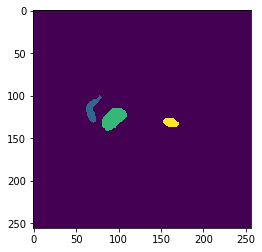

In [118]:
plt.imshow(t2spir_msks_arr)

In [126]:
np.unique(t2spir_msks_arr)

Array([  0,  63, 126, 189], dtype=uint8)

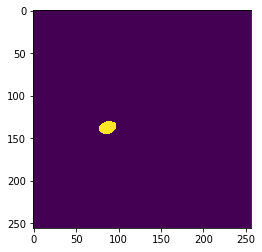

In [117]:
plt.imshow(t1dual_msks_arr)

In [125]:
dice_coeff_bet_imgs(t1dual_msks_arr,t2spir_msks_arr,126)

0.37844940817549355

In [111]:
t2spir_msks_arr_lvr=t2spir_msks_arr[t2spir_msks_arr==63]
t1dual_msks_arr_lvr=t1dual_msks_arr[t1dual_msks_arr==63]
t1dual_msks_arr_lvr.shape

(1301,)

In [105]:
t2spir_msks_arr_lvr_bin=np.where(t2spir_msks_arr==63,1,0)
t2spir_msks_arr_lvr_bin.shape

(288, 288)

In [ ]:
intersection = np.logical_and(im1, im2)

In [82]:
uniq_orgs_t2spir

Array([  0,  63, 126, 189, 252], dtype=uint8)

In [62]:
orgs_in_t2spir

['Background', 'r_kidney']

In [110]:
t2spir_msks

'D:\\Biomedical images\\Train\\NIFTI_MR_256x256 seg_rename\\NIFTI_MR_256x256_png_256grey_lvl\\t2spir\\ground\\pat_id_8_t2spir_slice_no_9_256grey_lvl_256x256.png'

In [60]:
t1dual_msks

'F:\\Biomedical images\\Train\\NIFTI_MR_256x256 seg_rename\\NIFTI_MR_256x256_png_256grey_lvl\\t1dual_inphase\\ground\\pat_id_10_t1dual_inphase_slice_no_10_256grey_lvl_256x256.png'

In [57]:
orgs_in_t2spir

['Background', 'r_kidney']

In [29]:
def dice_coeff_bet_imgs(seg,gt,k):
    """Determining dice coefficient between masks"""
    dice = np.sum(seg[gt==k]==k)*2.0 / ((np.sum(seg[seg==k]==k) + np.sum(gt[gt==k]==k))+1e-06)

    return dice

In [30]:
def checking_matches(t1dual_grnd_masks,t2spir_grnd_masks,
                     str_chk1='t1dual',str_chk2='t2spir'):
    """the purpose of this method is to evauate where there are no matches on a per slice per patient basis between the different image types. """
    
    #Creating unique slices number information for file set. 
    t1dl_msk_lsts=[]
    no_matches=[]
    for t1dl_msk in t1dual_grnd_masks:
        t1dl_msk=os.path.basename(t1dl_msk)
        file_info_split_t1d=t1dl_msk.split('_')
        #finding match basedo nstring type
        if str_chk1=='t1dual':
            t1dl_msk_info_tmp=file_info_split_t1d[2]+'_'+file_info_split_t1d[7]
        else:
            t1dl_msk_info_tmp=file_info_split_t1d[2]+'_'+file_info_split_t1d[6]
            
        t1dl_msk_lsts.append(t1dl_msk_info_tmp)
    i=0
    for t2spr_msk in t2spir_grnd_masks:
        t2spr_msk=os.path.basename(t2spr_msk)
        file_info_split=t2spr_msk.split('_')
        
        if str_chk2=='t2spir':
            t2spr_info=file_info_split[2]+'_'+file_info_split[6]
        else:
            t2spr_info=file_info_split[2]+'_'+file_info_split[7]

        find_match=[t1dl_msk_lst_itm for t1dl_msk_lst_itm in t1dl_msk_lsts if t2spr_info==t1dl_msk_lst_itm]
        
        if len(find_match)==0:
            #print('No match found:',t2spr_msk)
            
            no_matches.append(t2spr_msk)
    return no_matches